In [6]:
using Plots

In [7]:
globalFuzzMin = -0.01
globalFuzzMax =  0.01
globalFuzzVal =  0.0
FuzzInput(t) = t + globalFuzzVal;

In [8]:
minValue =  99999999
maxValue = -99999999

function PrintMinMax()
    @show minValue
    @show maxValue    
end

function ResetGlobalMinMax()
    global minValue
    global maxValue   
    minValue = 999999999
    maxValue = -99999999
end

function TrackMinMax(t)
    global minValue
    global maxValue
    minValue = t < minValue ? t : minValue
    maxValue = t > maxValue ? t : maxValue
    return t
end;

In [39]:
function FindAttachmentPoints(expr, maxid = 0, symbolExclusion = names(Base))
    ids = []
    id = maxid
    if(typeof(expr) == Expr)
         # Handle expressions
         push!(ids,(id,expr))   
         for i in 1:length(expr.args)
             id = id + 1
             newIds, id = FindAttachmentPoints(expr.args[i], id, symbolExclusion)
             ids = vcat(ids, newIds)
         end
    elseif(typeof(expr) == Symbol)
         # Handle Symbols - We cant fuzz functions directly. Only the result through :call
         if ( !(expr in symbolExclusion) )
             push!(ids,(id,expr))
         end
    elseif ( isa( (expr), Number ) )
         push!(ids, (id,expr))  
    else
         println("Unknown type submitted: $(typeof(expr))")
    end
        
    return ids, id
end

function ReplaceTree(expr, replacementID, functionName, maxid = 0)
    id = maxid
    if(id == 12345678) return 12345678 end
    if(typeof(expr) == Expr)
         # Handle expressions
         for i in 1:length(expr.args)
             id = id + 1
             if(id == replacementID)
                 fuzzTarget = expr.args[i]
                 replacementExpr = Expr(:call, functionName, fuzzTarget)
                 expr.args[i] = replacementExpr
                 return 12345678
             elseif(id > replacementID)
                 if(id != 12345678)
                     println("$id -> Unable to replace function: $(expr)")
                 end
                 return 12345678
             end
            
             id = ReplaceTree(expr.args[i], replacementID, functionName, id)
             if(id == 12345678) return 12345678 end
         end
    end
    
    id
end

ReplaceTree (generic function with 2 methods)

In [45]:
macro FuzzTestAll(expr)
    quote
        println("Find Attachment Points")
        res, maxid       = FindAttachmentPoints($expr)
        attachPointCount = length(res)
        println("Found $attachPointCount attach points (2 Invalid)")

        inputRange =  0.0:0.01:1.0
        fuzzRange  = -0.5:0.01:0.5

        resultGraphs= []
        for p in res[3:end]
            println(p)
            tCopyFuzz = deepcopy($expr)
            ReplaceTree(tCopyFuzz, p[1] , :FuzzInput)
            execFunc  = eval(tCopyFuzz)

            function testPointLocal(x, fuzz)
                global globalFuzzVal
                globalFuzzVal = 0.0
                sourceResult  = execFunc(x)
                globalFuzzVal = fuzz
                fuzzResult    = execFunc(x)      
                dif           = sourceResult - fuzzResult
            end 

            gr = plot(inputRange, fuzzRange, (x,y)-> testPointLocal(x,y), st=:surface, title="$(p[2])", xlabel="Input", ylabel="Fuzz", zlabel="Error")
            push!(resultGraphs, gr)
        end

        resultGraphs
    end
end

macro displayall(graphlist)
    quote
        for g in $graphlist
            display(g)
        end
    end
end

@displayall (macro with 1 method)

Find Attachment Points
Unknown type submitted: LineNumberNode
Found 14 attach points ("2 Invalid")
(2, quote
    #= In[46]:2 =#
    1 / x + x ^ 2 + 0.05 * sin(x)
end)
(4, :(1 / x + x ^ 2 + 0.05 * sin(x)))
(6, :(1 / x))
(8, 1)
(9, :x)
(10, :(x ^ 2))
(12, :x)
(13, 2)
(14, :(0.05 * sin(x)))
(16, 0.05)
(17, :(sin(x)))


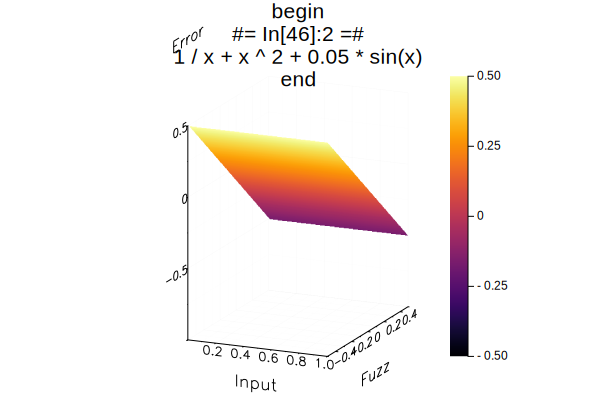

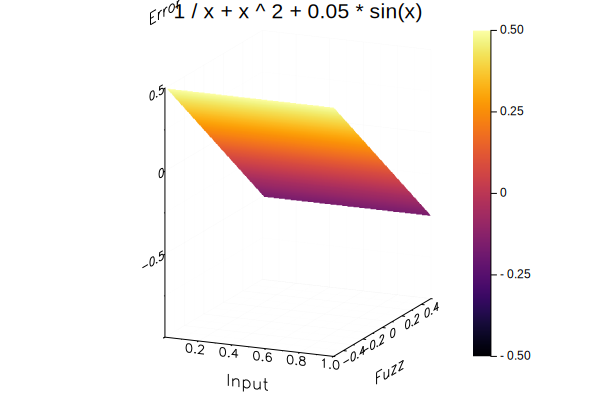

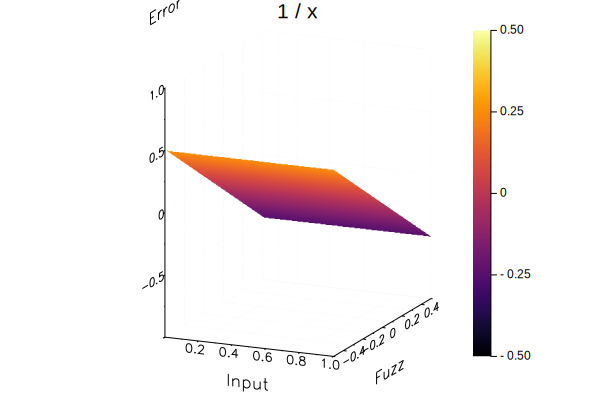

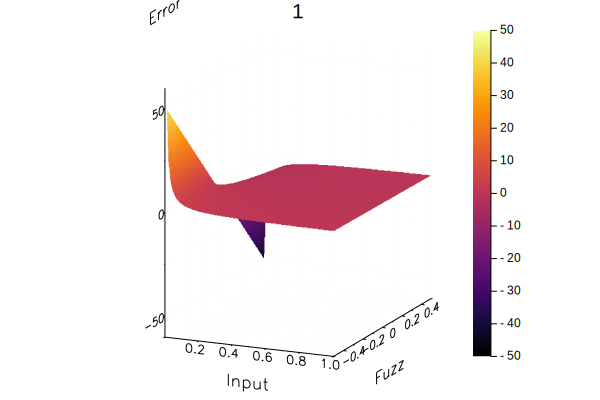

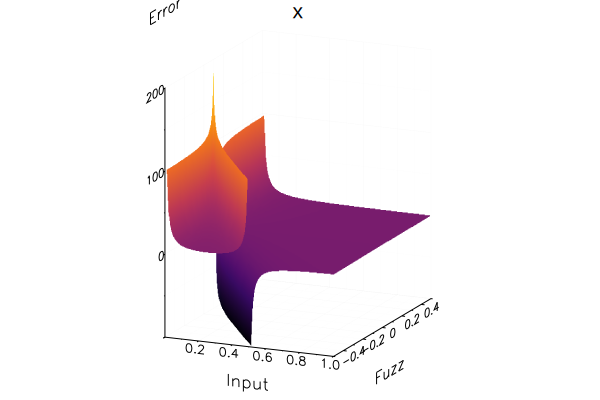

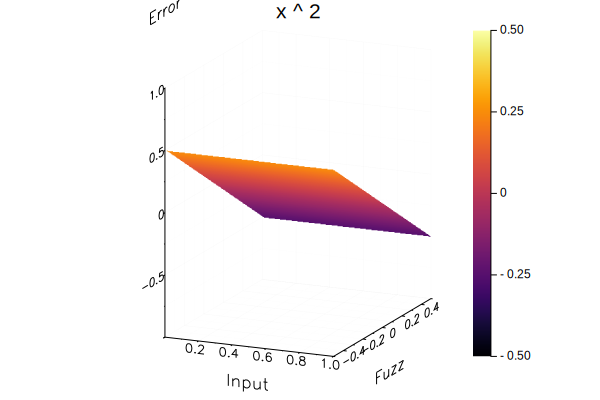

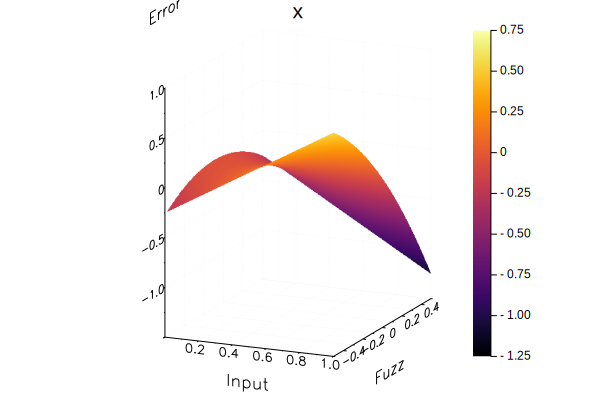

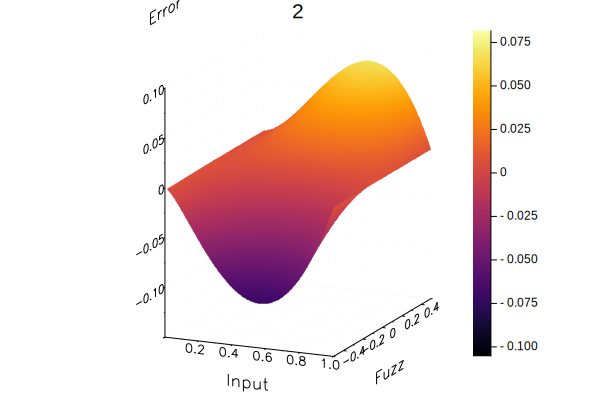

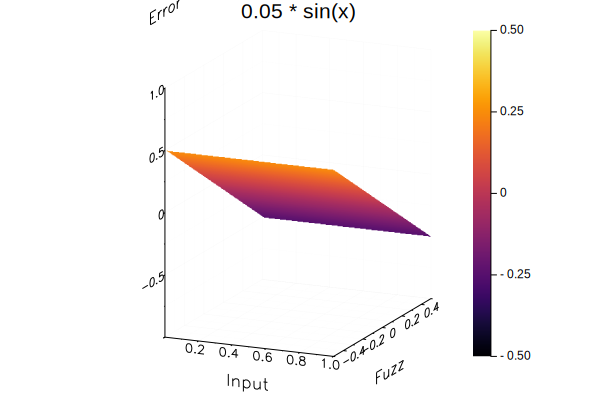

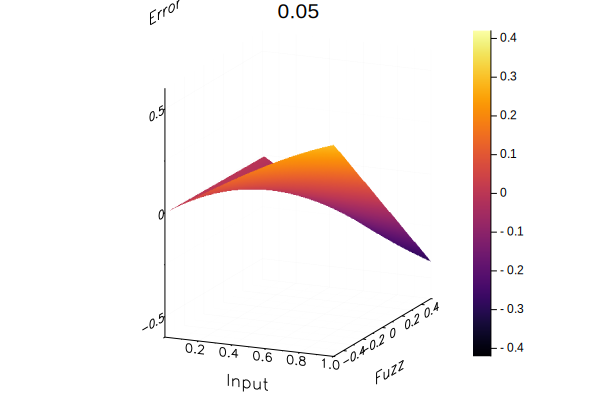

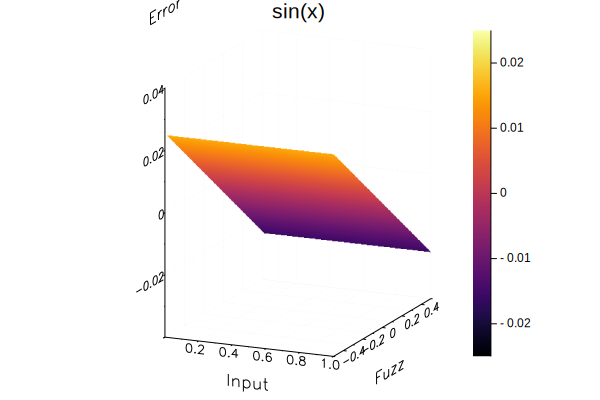

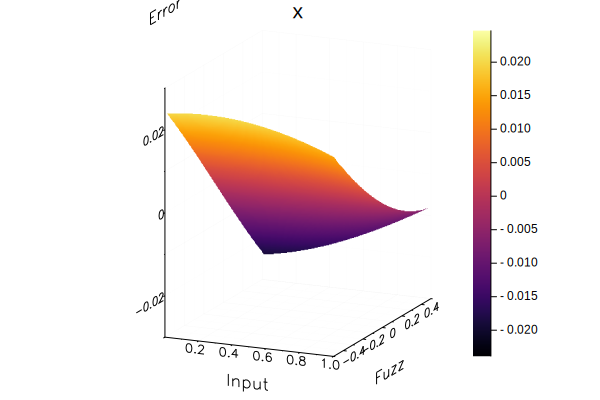

(19, :x)


GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
origin outside current window


In [46]:
# TEST
t = :(x -> (1/x) + (x^2) + 0.05 * sin(x))
grs = @FuzzTestAll t 
@displayall(grs)